# Water Allocation Simulation Analysis
This notebook provides tools to analyze the results of the water allocation simulation
across multiple scenarios, focusing on ecological and economic impacts under different
conditions.

## Overview
The simulation tests water allocation policies across various scenarios with different:
- River basins (station configurations)
- Actor compositions
- Water scarcity levels
- Forecast error profiles (bias and uncertainty)

The analysis evaluates how these factors affect both ecological integrity and economic benefits.


In this notebook we will:
1. Run the set of evaluation scenarios varying station size, scarcity level,  
   forecast bias and uncertainty.
2. Collect ecological and economic impact metrics for each run.
3. Visualize trade-offs and explore how model parameters influence outcomes.

In [7]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from types import MethodType
import src.core as wms
import src.plot_analysis as gtp
import src.utils as utils
import src.policies.incentive_policies as eip
import src.policies.quota_policies as eqp
import src.scenarios as sc
import src.plot_multi_analysis as pma
from src.optim import EvolutionnarySearch
import random

# Set better visualization defaults
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

In [8]:
# Define quota policy - determines how much water each actor is allowed to pump
# This uses the hard_quota policy from the quota_policies module
# In crisis situations, actors with priority below the crisis level get zero quota


class CrisisLevel:
    NORMAL = -1
    ALERT = 0
    CRISIS = 1
    EXTREME_CRISIS = 2


def tuned_make_quota_function(self, params):
    """
    Based on given parameters it generate a quota policy.

    Returns:
        func: Quota policy.
    """
    def tuned_quota(
        self,
        crisis_level: int,
        actors_priority: np.ndarray,
        avg_pump: np.ndarray,
        DOE: float,
        DCR: float,
        ) -> np.ndarray:
        """
        Hard quota policy based on priority and crisis level.
        
        Sets quotas to zero for actors with priority less than the current crisis level.
        
        Args:
            crisis_level: Current water crisis level.
            actors_priority: Priority levels for each actor.
            avg_pump: Average pumping for each actor.
            DOE: Ecological optimal flow threshold.
            DCR: Crisis flow threshold.
            
        Returns:
            Array of water quotas for each actor.
        """

        # This will make higher priority actors having bigger quotas
        proportional_priority_factor = 1 + ((actors_priority + 1) / 10)

        if crisis_level == CrisisLevel.NORMAL:
            # Actors will be assigned bigger quotas to avoid them getting penalties and so pumping more
            return (avg_pump * 
                    params["NORMAL_GROWTH_FACTOR"] * 
                    proportional_priority_factor)
        
        else:
            # Crisis times we estimate the available water and we distribute it according to the priority of the actors 
            # Until it reach the ecological acceptable flow
            maximum_amount = 0.0

            match crisis_level:
                case CrisisLevel.ALERT:
                    maximum_amount = DOE 
                case CrisisLevel.CRISIS:
                    maximum_amount = (DOE + DCR) / 2 
                case CrisisLevel.EXTREME_CRISIS:
                    # When already bellow the ecological flow, we don't want anyone to pump
                    return np.zeros_like(avg_pump)

            estimated_flow =  maximum_amount * params["ESTIMATION_FACTOR"]

            # Repartition by actor priority
            # Sort actors by priority, get indices
            sorted_indices = np.argsort(-actors_priority)
            quotas = np.zeros_like(avg_pump)

            for idx in sorted_indices:
                if estimated_flow <= DCR:
                    # If the remaining water is less than DCR, stop allocating, default value already 0
                    break
                pump = (avg_pump[idx] * 
                        params["CRISIS_PUMPING_RESTRICTION"] *
                        proportional_priority_factor[idx])
                if estimated_flow - pump >= DCR:
                    quotas[idx] = pump
                    estimated_flow -= pump
                else:
                    # If the remaining water is less than DCR the actor can't pump
                    quotas[idx] = 0

            return quotas
    return tuned_quota


def tuned_make_incentive_function(self, params):
    """
    Based on given parameters it generate an incentive policy.

    Returns:
        func: Incentive policy.
    """
    def tuned_incentive_policy(self,
                        actions: np.ndarray,
                        actors_priority: np.ndarray,
                        avg_incomes: np.ndarray,
                        water_pump: np.ndarray,
                        avg_pump: np.ndarray,
                        is_crisis: np.ndarray,
                        water_flows: np.ndarray,
                        quota: np.ndarray,
                        DOE = 15,
                        DCR = 10) -> np.ndarray:
        """
        Custom incentive policy that applies fines for exceeding quota and subsidies for cooperation.
        
        Returns an array of incentives (positive values = fines, negative values = subsidies)
        """
        fine = np.zeros(self.nb_actors)
        crisis_level = is_crisis[-1]  # Current crisis level
        
        # If average income is negative, replace it with 0
        avg_incomes = np.where(avg_incomes < 0, 0, avg_incomes)
        critical_overall_demand_treshold = np.sum(avg_pump) + DCR


        for i in range(self.nb_actors):

            # Adjusting so the priority value is [0,0.25] range
            actor_priority = (actors_priority[i] - 0) / (8 - 0)
            # Then we increase the gap between P0 and P1 
            # This is because it is significativly more important that they respect quotas
            # Finally we get [0, 0.4, 0.8] so a [0, 0.8] interval
            ACTOR_GAP = 0.5
            actor_priority += actor_priority * ACTOR_GAP
            
            # Epsilon [0,0.5] param will help to select the right proportion of policy increase in [0,1] range so the inverse function will be stricly positive          
            adjusted_priority = params["EPSILON_PRIORITY"] + actor_priority
            # Higher the priority is, lower the factor will be, but factor will still be > 1
            adjusted_priority_factor = ((1 / adjusted_priority) / 2)

            # As the simulation penalizes less subsidies we push more on it than fines
            SUBSIDY = -(
                # We make 5 times bigger subsidy as the simulation penalize 5 times less
                # So our politics align with the game rules and prefer pushing coop through subsidies rather than fines 
                (avg_incomes[i] * (params["FINE_INCOME_BASE_CALCULATION"] * 5)) * 
                adjusted_priority_factor
            )
            FINE = (
                (avg_incomes[i] * params["FINE_INCOME_BASE_CALCULATION"]) * 
                adjusted_priority_factor
            )

            # print("------------------")
            # print("actor prio:", actors_priority[i])
            # print("adjusted_priority_factor:", adjusted_priority_factor)
            # print("avg_incomes[i]:", avg_incomes[i])
            # print("params[FINE_INCOME_BASE_CALCULATION]:", params["FINE_INCOME_BASE_CALCULATION"])
            # print("FINE", FINE)
            # print("SUBSIDY", SUBSIDY)
            # print("------------------")


            if water_flows[-1] < critical_overall_demand_treshold and crisis_level == CrisisLevel.NORMAL:
                # We anticipate a near crisis situation so we start applying fines
                # But it won't be as strong as in a real crisis
                if (water_pump[i] > quota[i]):
                    fine[i] = FINE * params["ANTICIPATION_FACTOR"]
                elif (water_pump[i] <= quota[i]):
                    fine[i] = SUBSIDY * params["ANTICIPATION_FACTOR"]
            else:

                match crisis_level:
                    case CrisisLevel.NORMAL:
                        # For the moment, normal times will be free from fines and subsidies
                        return np.zeros_like(avg_pump)
                    
                    case CrisisLevel.ALERT | CrisisLevel.CRISIS | CrisisLevel.EXTREME_CRISIS :
                        # The more the crisis is critical, the more the fine/subsidies will be
                        # [1.2, 1.3, 1.4]
                        crisis_factor = 1 + ((crisis_level + 2) / 10)
                        
                        # Defectors
                        if (water_pump[i] > quota[i]) :
                            if actors_priority[i] <= crisis_level:
                                fine[i] = (
                                    FINE * 
                                    params["NON_PRIORITY_ACTORS_INCREASE"] *
                                    crisis_factor
                                )
                            else:
                                fine[i] = FINE 
                        # Cooperators
                        elif (water_pump[i] <= quota[i]):
                            if actors_priority[i] <= crisis_level:
                                fine[i] = (
                                    SUBSIDY * 
                                    params["NON_PRIORITY_ACTORS_INCREASE"] * 
                                    crisis_factor
                                )
                            else:
                                fine[i] = SUBSIDY 

        return fine
    return tuned_incentive_policy


def tuned_generate_individuals(self):
    """
    Generate required params for both policies.

    Returns:
        dict: Dictionary containing parameters for both incentive and quota policies \n
        {
            "incentive_params":{...},\n
            "quota_params": {...}
        }
    """
    return {
        "incentive_params": {
            # The lower it is, the less anticipation fines and subsidies will be
            #   ]0, 2]
            #   e.g : 0.6 => 60% of the real crisis fine
            "ANTICIPATION_FACTOR": random.uniform(0.1, 1.6),
            # The higher it is, more the low priority actors breaking/respecting 
            # Quota and priority rule will be penalized/rewarded, this aims to keep priority order
            #   [1, 2]
            #   e.g : 1.2 => 120% of initial fine/subsidy
            "NON_PRIORITY_ACTORS_INCREASE": random.uniform(1, 2),
            # This will indicate how strong will be the additional subsidy/fine 
            # When low priority actors exceed their quota in crisis times
            #   ]0, 1]
            #   e.g : 0.10 => 10% of the average income
            # "SUBSIDY_INCOME_BASE_CALCULATION": random.uniform(0.15, 3),
            # This will indicate on wich amount the fine will be calculated
            # The higher it is, the closer it gets to the actor average income
            #   ]0, 1]
            #   e.g : 0.10 => 10% of the average income
            "FINE_INCOME_BASE_CALCULATION": random.uniform(0.001, 0.5),
            # This will accentuate the exponentinality of subsidy/fine policy based on actor priority
            #   ]0, 1]
            #   e.g : 0.25 => Closer to zero, applied to inverse function, will impact P0(0.25 -> 1/0.25=4) 5 times more than P1(1.25 -> 1/1.25=0.8)
            #   e.g : 0.9 => Closer to one, applied to inverse function, will impact P0(0.9 -> 1/0.9=1.1) ~2.1 times more than P1(1.9 -> 1/1.9=0.52)
            "EPSILON_PRIORITY": random.uniform(0.01, 0.35)
        },
        "quota_params": {
            # The bigger it is, more the actors will be allowed to pump in normal times
            #   [1, +inf]
            #   e.g : 1.15 => 15% more than the average pump
            "NORMAL_GROWTH_FACTOR": random.uniform(1.05, 1.5),
            # The lower it is, the more pessimistic the allocation will be
            #   ]0, 1]
            #   1 => maximum estimation possible (e.g : CrisisLevel.ALERT = DOE )
            #   0.05 => maximum estimation * 0.05 (e.g : CrisisLevel.ALERT = 5% of DOE )
            "ESTIMATION_FACTOR": random.uniform(0.05, 1),
            # The lower it is, the less actors will be allowed to pump in crisis times 
            #   [0, 1] 
            #   1 => 100% of average pump 
            #   0 => 0% of average pump
            "CRISIS_PUMPING_RESTRICTION": random.uniform(0.05, 1),
        },
    }

In [9]:
# scenario_0_best_ind = pd.read_csv("./optimization_results/best_ind_scenario_0.csv")
# scenario_1_best_ind = pd.read_csv("./optimization_results/best_ind_scenario_1.csv")

scenario_0_best_ind = {
    "incentive_params" : {
        "ANTICIPATION_FACTOR" : 0.824090,
        "NON_PRIORITY_ACTORS_INCREASE" : 1.656258,
        "FINE_INCOME_BASE_CALCULATION" : 0.495915,
        "EPSILON_PRIORITY" : 0.794051,
    },
    "quota_params" : {
        "NORMAL_GROWTH_FACTOR" : 1.138868,
        "ESTIMATION_FACTOR" : 0.136074,
        "CRISIS_PUMPING_RESTRICTION" : 0.496883,

    }
}

scenario_1_best_ind = {
    "incentive_params" : {
        "ANTICIPATION_FACTOR" : 0.625001,
        "NON_PRIORITY_ACTORS_INCREASE" : 1.028437,
        "FINE_INCOME_BASE_CALCULATION" : 0.726719,
        "EPSILON_PRIORITY" : 0.350462,
    },
    "quota_params" : {
        "NORMAL_GROWTH_FACTOR" : 1.133417,
        "ESTIMATION_FACTOR" : 0.715128,
        "CRISIS_PUMPING_RESTRICTION" : 0.800660,

    }
}



yaml_path = 'parameters/scenarios/1.yml'  
params = utils.load_parameters_from_yaml(yaml_path)
params["total_turns"] = 500        # Number of weeks to simulate
params["nb_iterations"] = 10       # Number of simulation runs
params["scarcity"] = "medium"      # Water scarcity level
params["global_forecast_bias"] = -.5       # Bias in water flow forecasts
params["global_forecast_uncertainty"] = .9  # Uncertainty in forecasts
params["verbose"] = True  # Uncertainty in forecasts
# Initialize and run simulation
base_simulation = wms.WaterManagementSimulation(**params)

N_GEN = 1

search = EvolutionnarySearch(
    simulation=base_simulation,
    p_best_parents=2,
    pop_size=100,
    n_gen=N_GEN,
    mutation_rate=0.8, # Only 40% of genes will mutate at each generation, the less it is, the more stable evolution will be
    initial_mutation_spread=1, # Mutation will follow a random mutation (increase or decrease) in a normally distributed factor centered around 1, with your desired standard deviation (the bigger it gets, the bigger changes will be)  
    ecol_weight=1.1, # Focus a bit more on ecological impact
    econ_weight=1,
    priority_penalty=0.3 # Add a significative penalty for simulations that don't respect priority order (30% removed performance)
)

# Faut encore modifier les fonctions en make fonction et créer l'intialiseur
search.make_incentive_function = MethodType(tuned_make_incentive_function, search)
search.make_quota_function = MethodType(tuned_make_quota_function, search)
search.generate_individuals = MethodType(tuned_generate_individuals, search)

scenario_0_incentive = search.make_incentive_function(scenario_0_best_ind["incentive_params"])
scenario_1_incentive = search.make_incentive_function(scenario_1_best_ind["incentive_params"])

scenario_0_quota = search.make_quota_function(scenario_0_best_ind["quota_params"])
scenario_1_quota = search.make_quota_function(scenario_1_best_ind["quota_params"])

In [10]:
scenario_1_best_ind

{'incentive_params': {'ANTICIPATION_FACTOR': 0.625001,
  'NON_PRIORITY_ACTORS_INCREASE': 1.028437,
  'FINE_INCOME_BASE_CALCULATION': 0.726719,
  'EPSILON_PRIORITY': 0.350462},
 'quota_params': {'NORMAL_GROWTH_FACTOR': 1.133417,
  'ESTIMATION_FACTOR': 0.715128,
  'CRISIS_PUMPING_RESTRICTION': 0.80066}}

In [11]:
def cumul_incentive_policy(self,
                    actions: np.ndarray,
                    actors_priority: np.ndarray,
                    avg_incomes: np.ndarray,
                    water_pump: np.ndarray,
                    avg_pump: np.ndarray,
                    is_crisis: np.ndarray,
                    water_flows: np.ndarray,
                    quota: np.ndarray,
                    DOE = 15,
                    DCR = 10) -> np.ndarray:

#     if DOE == .1 and DCR == .05:
    if True:
     #     print("Using scenario_0_incentive")
         return scenario_0_incentive(self,
                    actions,
                    actors_priority,
                    avg_incomes,
                    water_pump,
                    avg_pump,
                    is_crisis,
                    water_flows,
                    quota,
                    DOE,
                    DCR)
    else:
         print("Using scenario_1_incentive")
         return scenario_1_incentive(self,
                    actions,
                    actors_priority,
                    avg_incomes,
                    water_pump,
                    avg_pump,
                    is_crisis,
                    water_flows,
                    quota,
                    DOE,
                    DCR)
    

def cumul_quota(
        self,
        crisis_level: int,
        actors_priority: np.ndarray,
        avg_pump: np.ndarray,
        DOE: float,
        DCR: float,
        ) -> np.ndarray:
#     if DOE == .1 and DCR == .05:
    if True:
         return scenario_0_quota(self,
                    crisis_level,
                    actors_priority,
                    avg_pump,
                    DOE,
                    DCR)
    else:
         return scenario_1_quota(self,
                    crisis_level,
                    actors_priority,
                    avg_pump,
                    DOE,
                    DCR)

## Scenario Definition
Runs simulations across the pre-defined scenarios.
We iterate over:
- **Stations**: Tarn vs. La Vézère  
- **Scarcity levels**: low / medium / high  
- **2 set of actors and variant with heterogenous biaises and uncertainties**  
- **Forecast bias/uncertainty** settings  

Execute the next cell to proceed multo-scenario analysis.

In [23]:
if False:
    results_df = sc.run_all_scenarios(
        turns=700,
        iterations=5,
        custom_incentive_policy=cumul_incentive_policy,
        custom_quota=cumul_quota)
    results_df.to_csv('results_delete_df.csv', index=False)
else:
# load results_df from csv
    results_df = pd.read_csv('results_delete_df.csv')


## Multi-Scenario Analysis


In [24]:
results_df

,ecological_impact,economic_impact,bias,uncertainty,scarcity,scenario,station,raw_ecological_impact,raw_economic_impact,cooperation_percentage,priority_ok,scarcity_color,scenario_color,scenario_name,station_color
0,0.990000,0.928154,0.00,0.00,low,1.yml,1,297.0,164922.700933,0.464657,0.0,yellow,red,1,green
1,1.000000,0.929631,0.00,0.25,low,1.yml,1,300.0,165185.220738,0.453800,0.0,yellow,red,1,green
2,1.003333,0.927920,0.00,0.50,low,1.yml,1,301.0,164881.129477,0.475829,0.0,yellow,red,1,green
3,0.963333,0.933285,0.25,0.00,low,1.yml,1,289.0,165834.530096,0.471171,0.0,yellow,red,1,green
4,0.956667,0.933305,0.25,0.25,low,1.yml,1,287.0,165837.976700,0.478171,0.0,yellow,red,1,green
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,0.765493,0.563355,0.00,0.00,high,1-v.yml,2,1117.0,4506.826009,0.618886,0.0,red,orange,1-v,blue
212,0.719718,0.556586,0.00,0.00,high,0-b.yml,2,1052.0,1983.351630,0.752600,0.0,red,blue,0-b,blue
213,0.802817,0.538221,0.00,0.00,high,1-b.yml,2,1170.0,4305.750516,0.588114,0.0,red,red,1-b,blue
214,0.730986,0.530538,0.00,0.00,high,0-c.yml,2,1068.0,1890.530862,0.718143,0.0,red,blue,0-c,blue


In [26]:
# viz_df = results_df[results_df["ecological_impact"] > 1]
viz_df = results_df[results_df["economic_impact"] > 0]

viz_df[["station", "scenario", "ecological_impact", "economic_impact"]]

,station,scenario,ecological_impact,economic_impact
0,1,1.yml,0.990000,0.928154
1,1,1.yml,1.000000,0.929631
2,1,1.yml,1.003333,0.927920
3,1,1.yml,0.963333,0.933285
4,1,1.yml,0.956667,0.933305
...,...,...,...,...
211,2,1-v.yml,0.765493,0.563355
212,2,0-b.yml,0.719718,0.556586
213,2,1-b.yml,0.802817,0.538221
214,2,0-c.yml,0.730986,0.530538


### Ecological vs. economic impact.

Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact


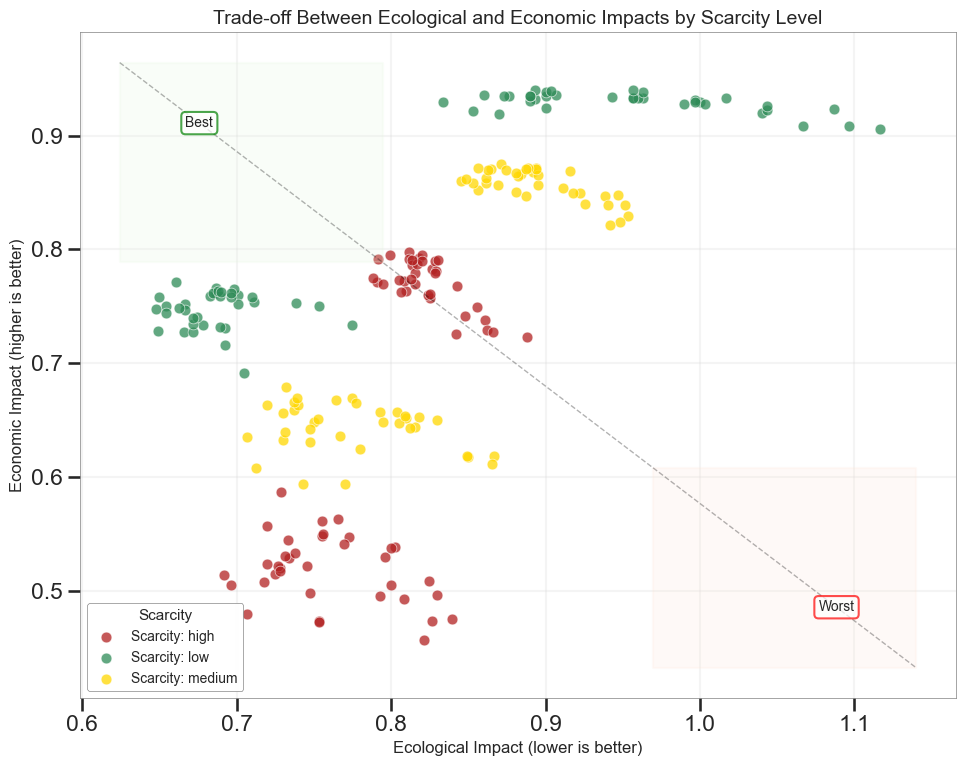

Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact


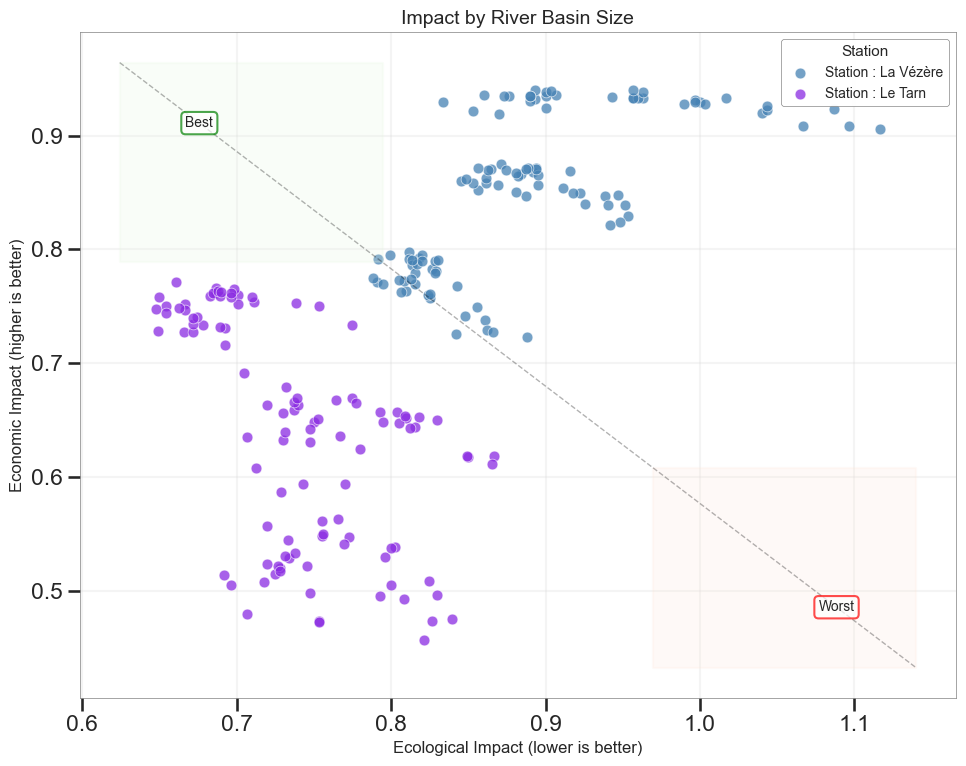

Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact


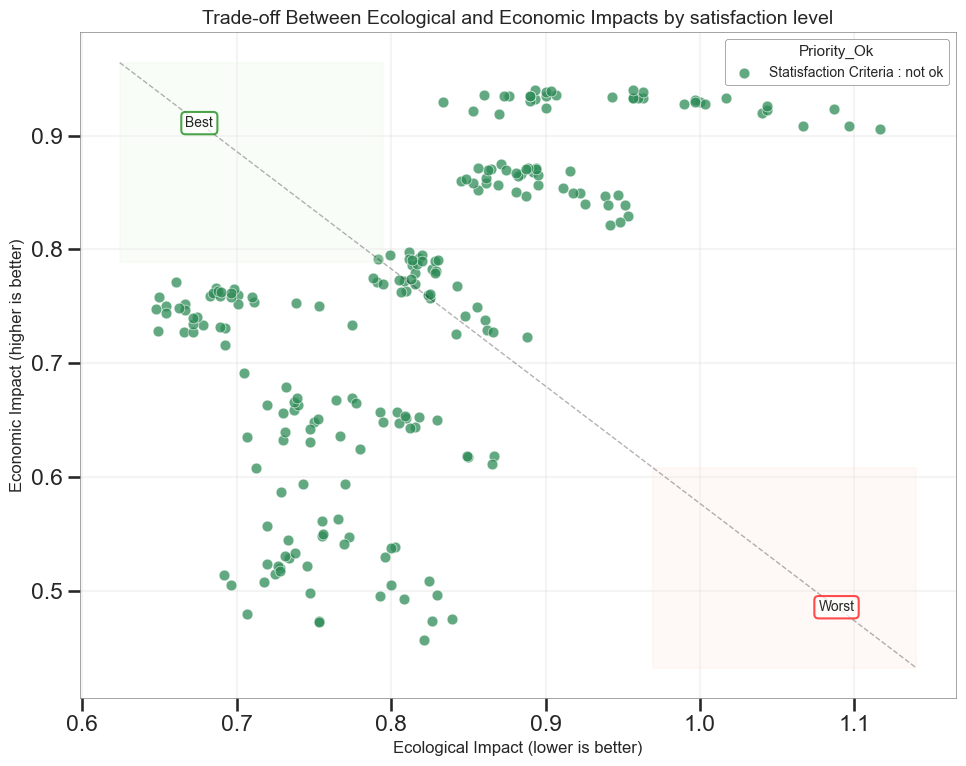

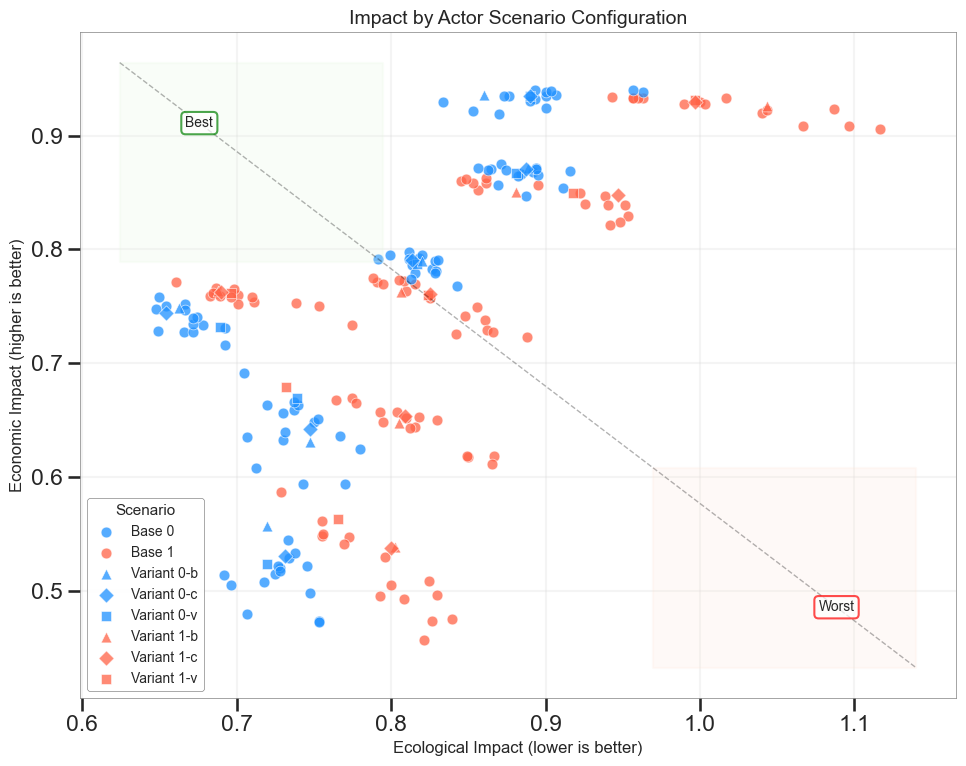

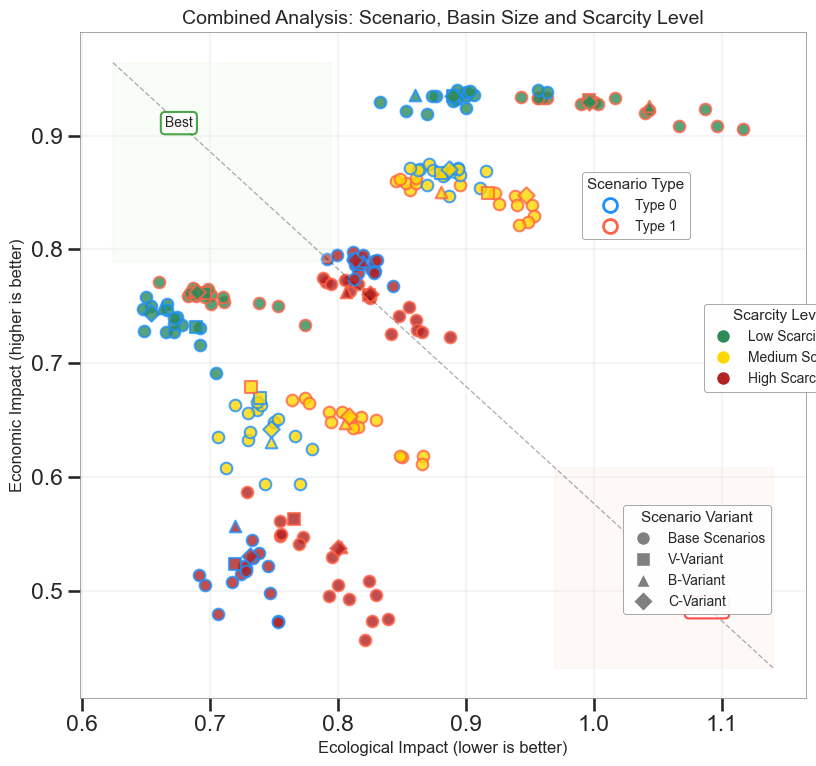

In [27]:
pma.analyze_scenario_impacts(viz_df, is_scalled=True)

Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact


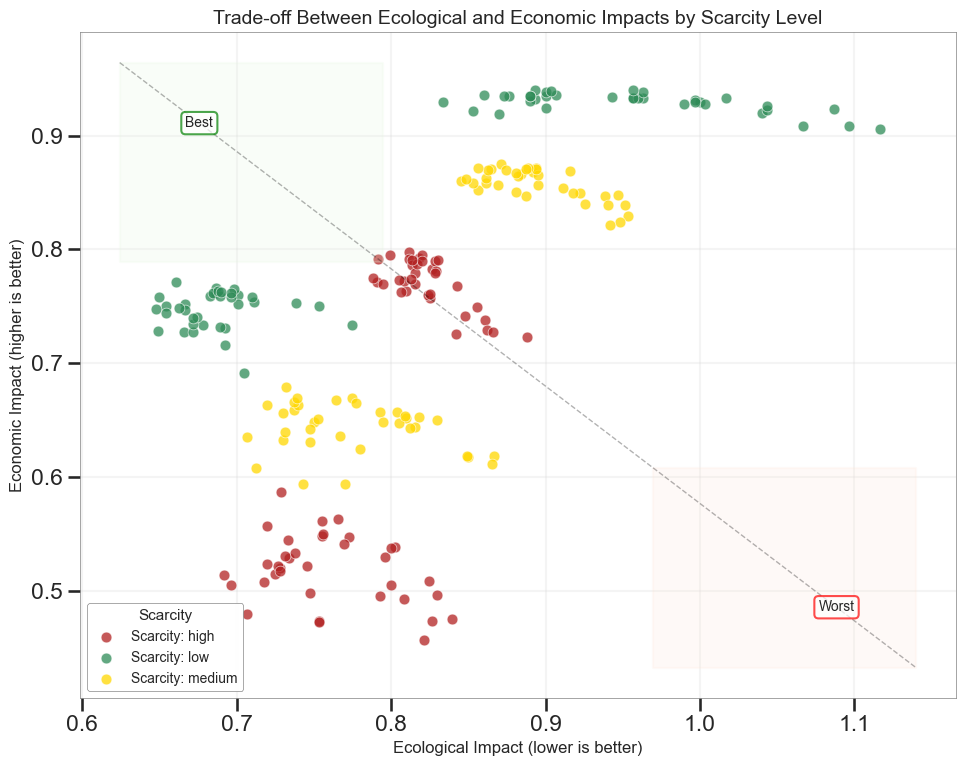

Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact


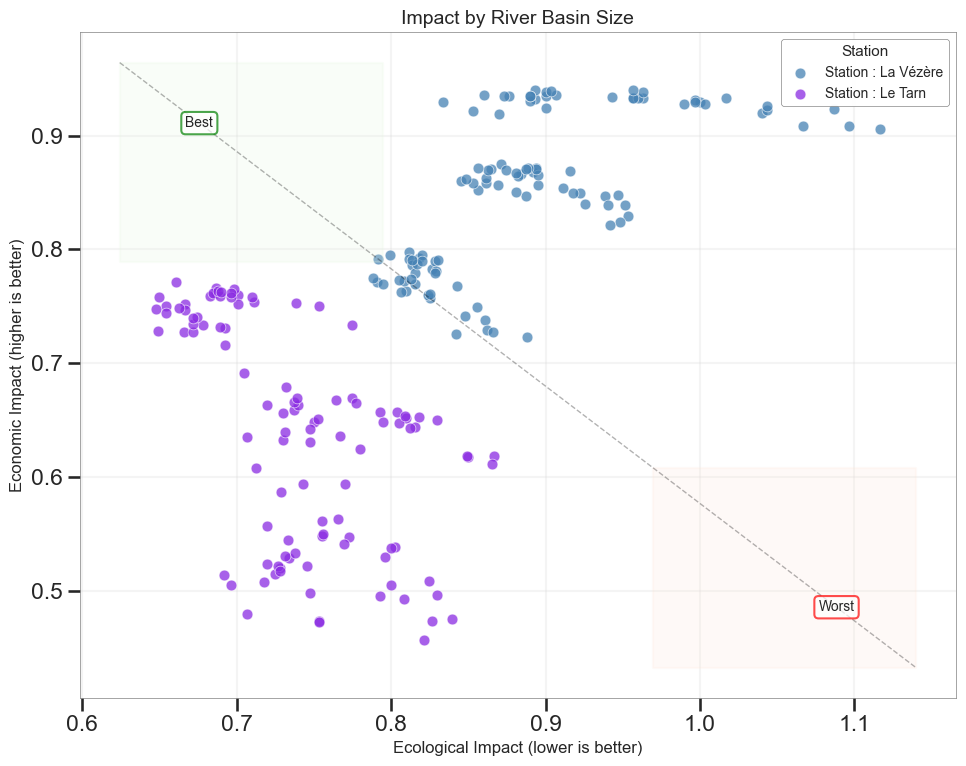

Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact


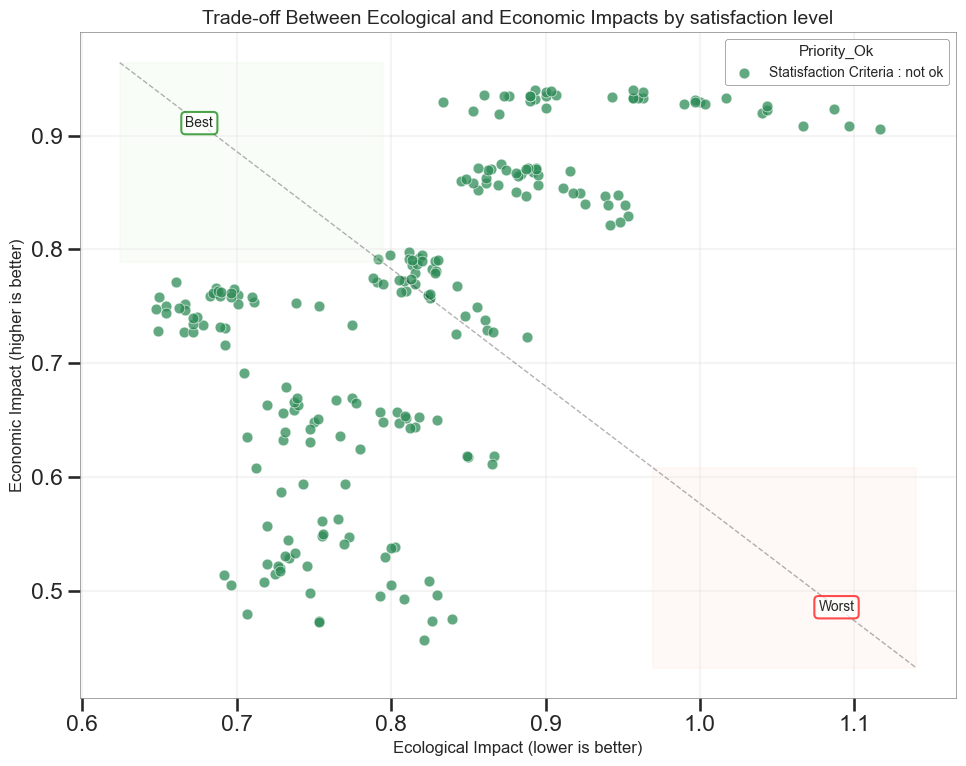

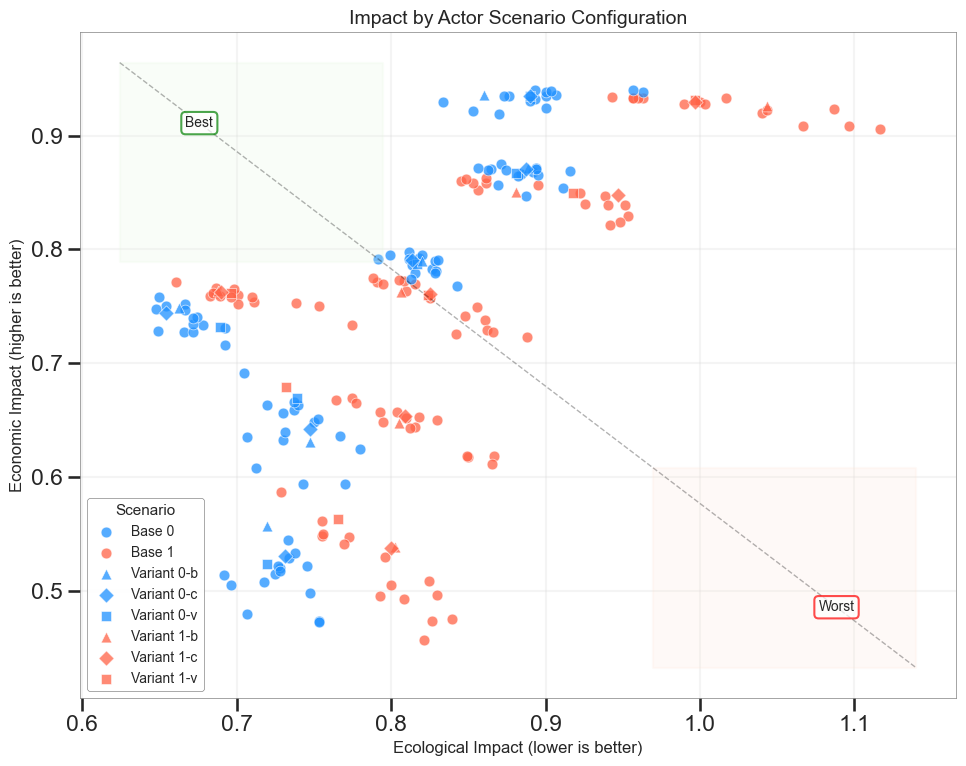

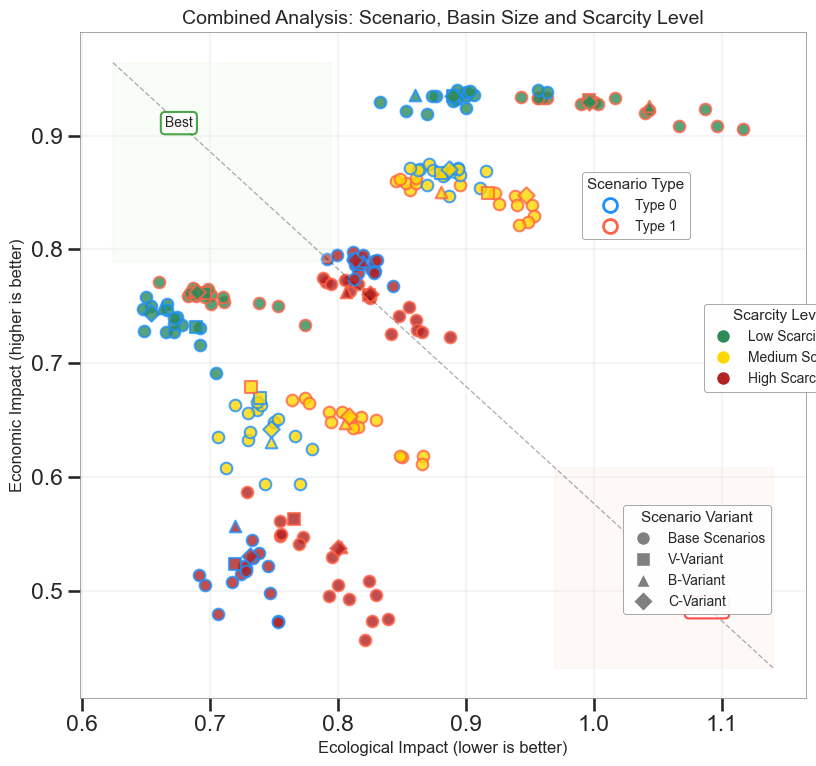

In [28]:
pma.analyze_scenario_impacts(results_df , is_scalled=True)

## Analyzing Forecast Bias & Uncertainty & Scarcity levels

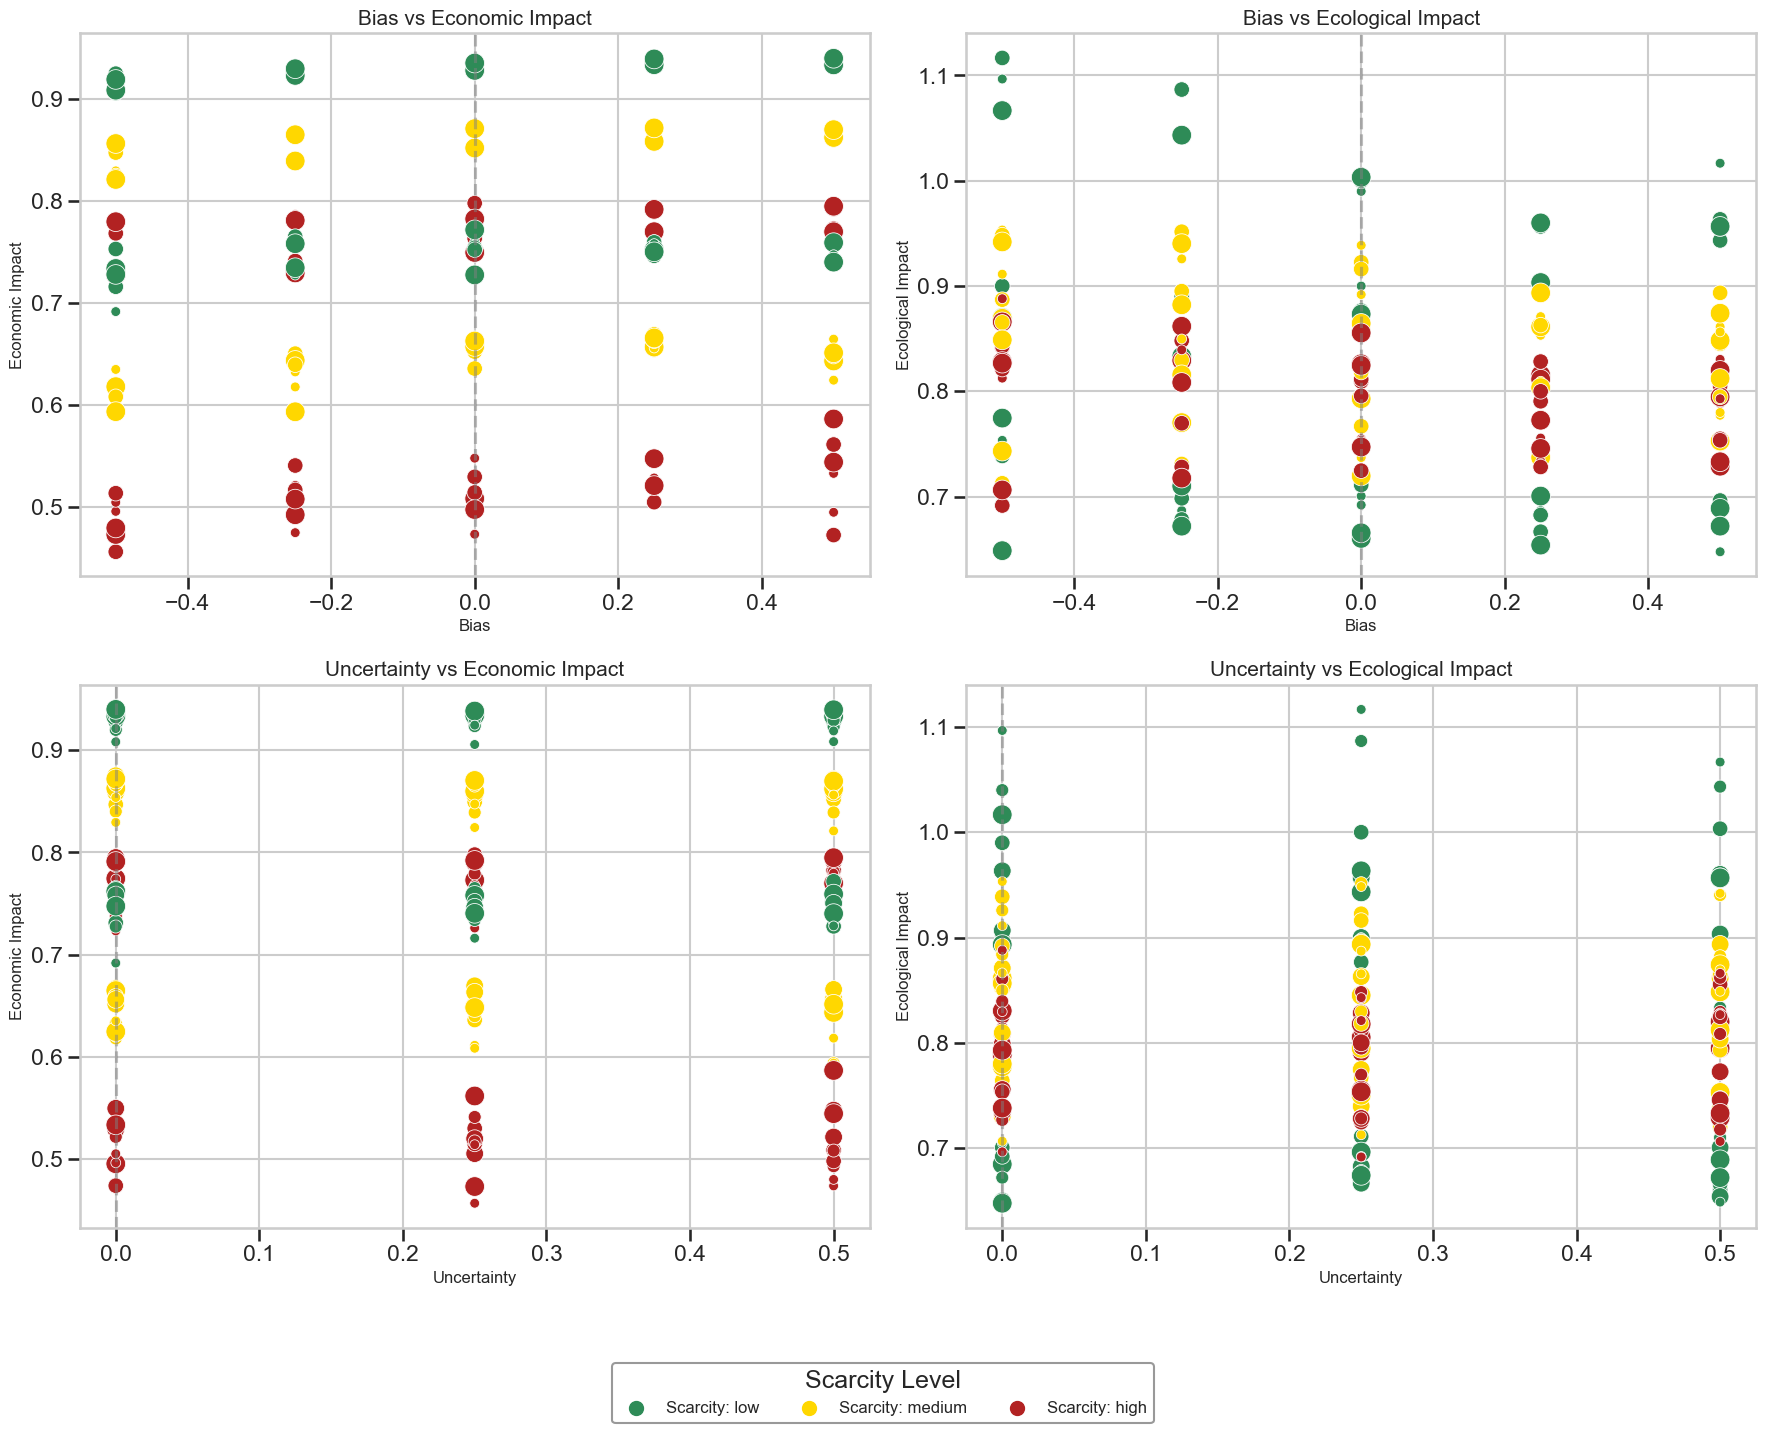

c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon.Phase2\WaterScarcity.Hackathon\src\plot_multi_analysis.py:351: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon.Phase2\WaterScarcity.Hackathon\src\plot_multi_analysis.py:351: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


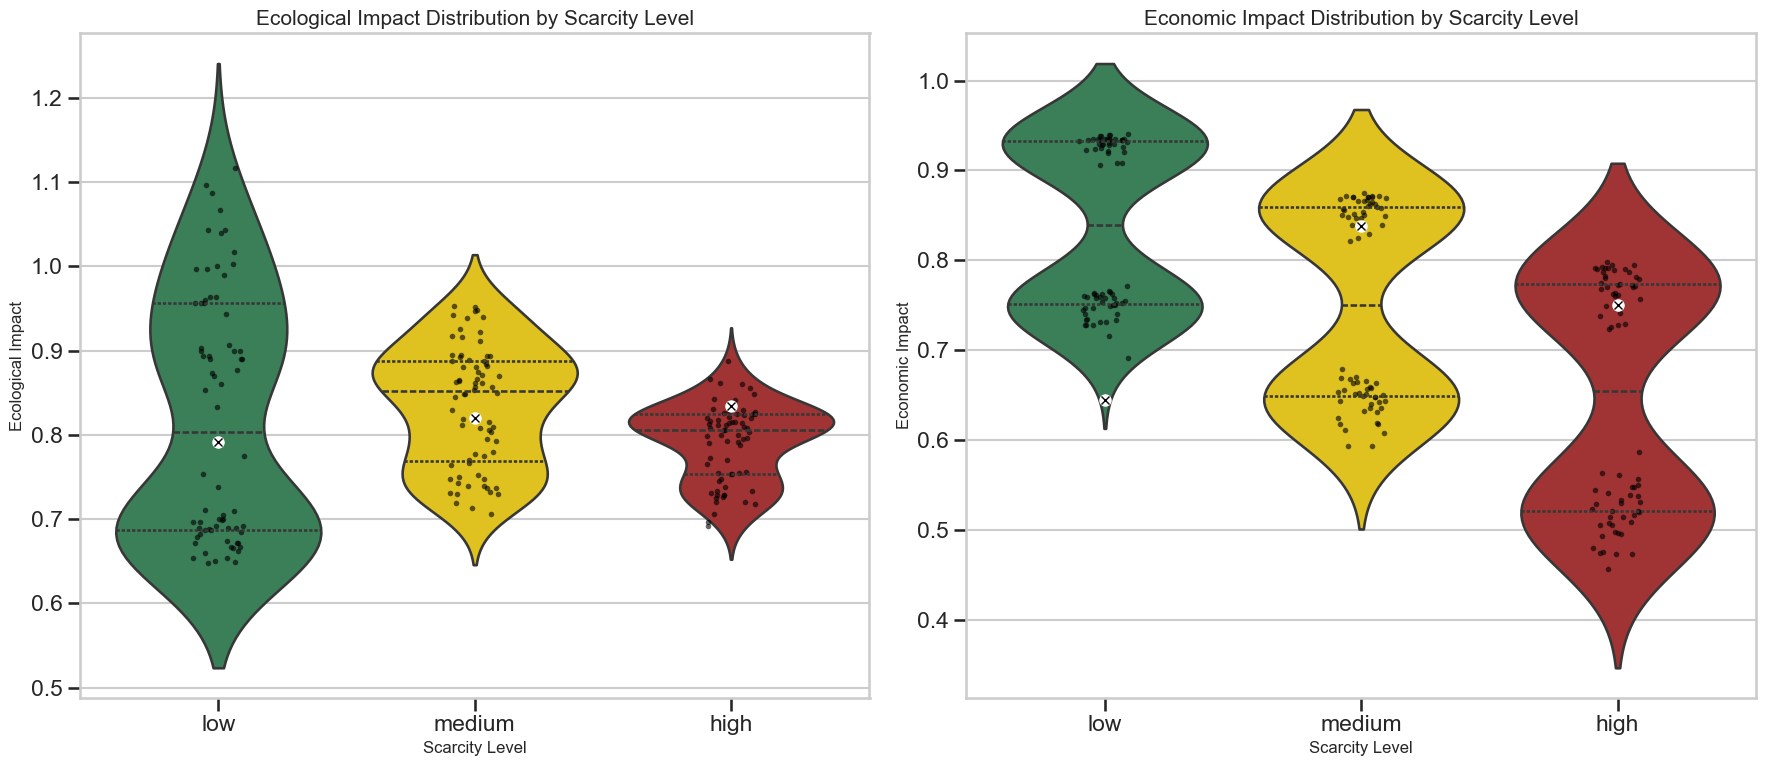

In [29]:
pma.analyze_forecast_effects(results_df, is_scalled=True)

## Correlation Analysis


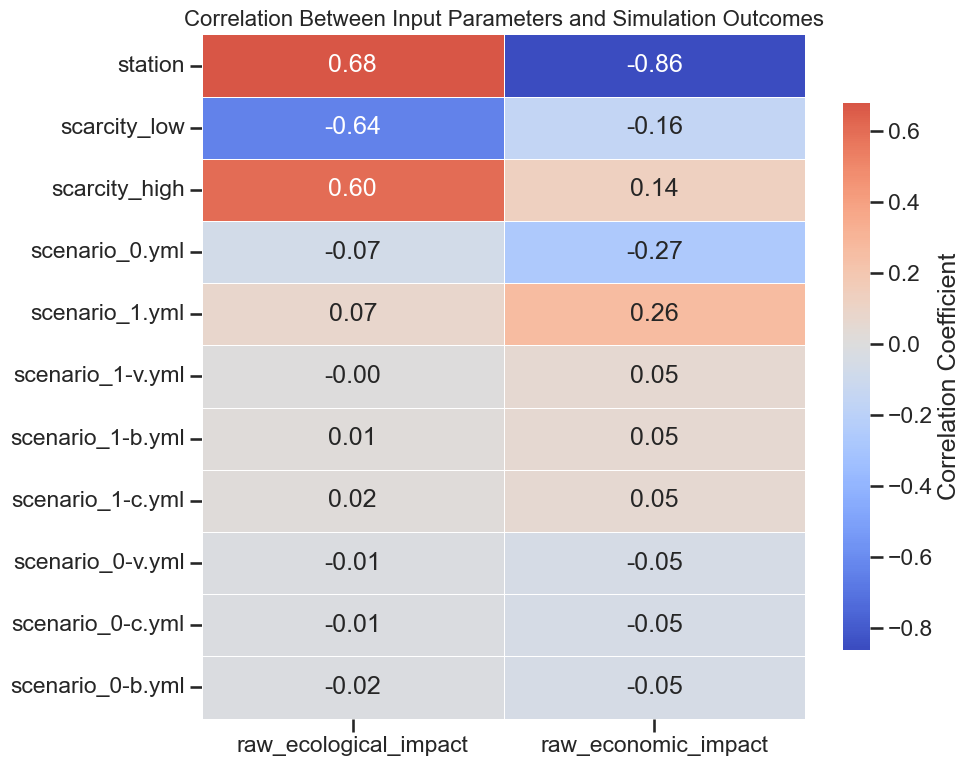


Top impacts on raw_ecological_impact:

Top 5 positive correlations:
  station: 0.679
  scarcity_high: 0.603
  scenario_1.yml: 0.074
  scarcity_medium: 0.038
  scenario_1-c.yml: 0.016

Top 5 negative correlations:
  scenario_0-c.yml: -0.014
  scenario_0-b.yml: -0.016
  bias: -0.033
  scenario_0.yml: -0.068
  scarcity_low: -0.641

Top impacts on raw_economic_impact:

Top 5 positive correlations:
  scenario_1.yml: 0.265
  scarcity_high: 0.136
  scenario_1-v.yml: 0.055
  scenario_1-b.yml: 0.054
  scenario_1-c.yml: 0.054

Top 5 negative correlations:
  scenario_0-c.yml: -0.053
  scenario_0-v.yml: -0.053
  scarcity_low: -0.155
  scenario_0.yml: -0.266
  station: -0.863


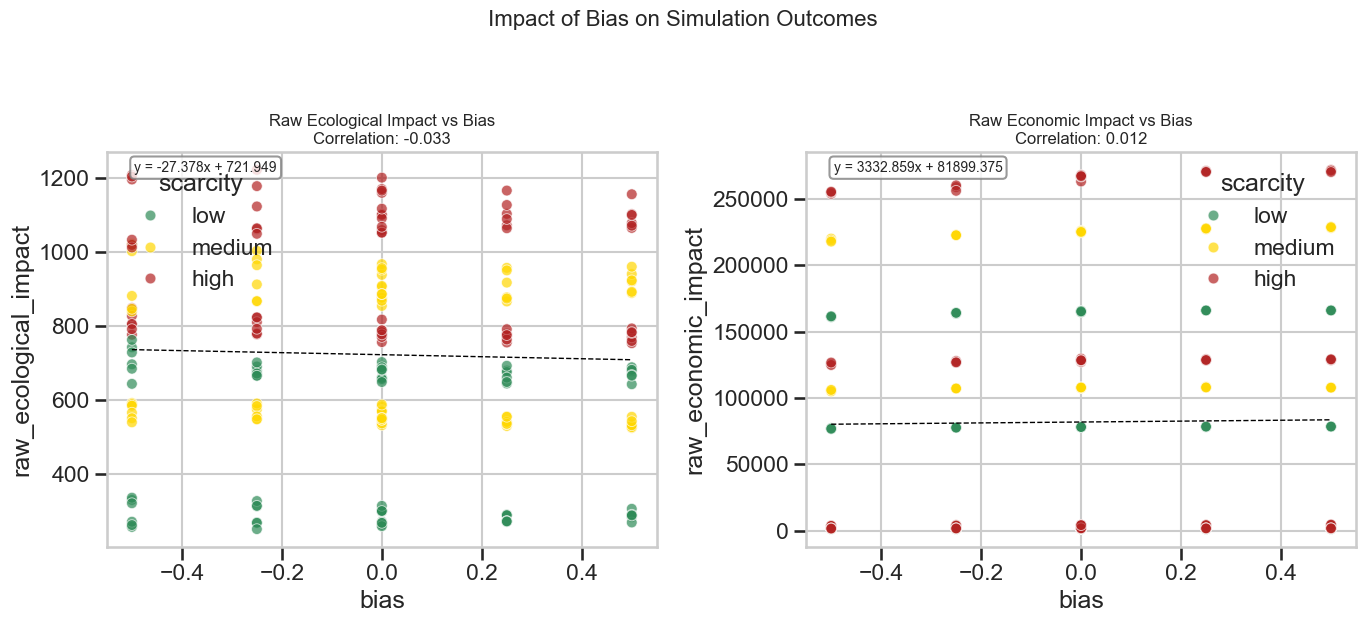

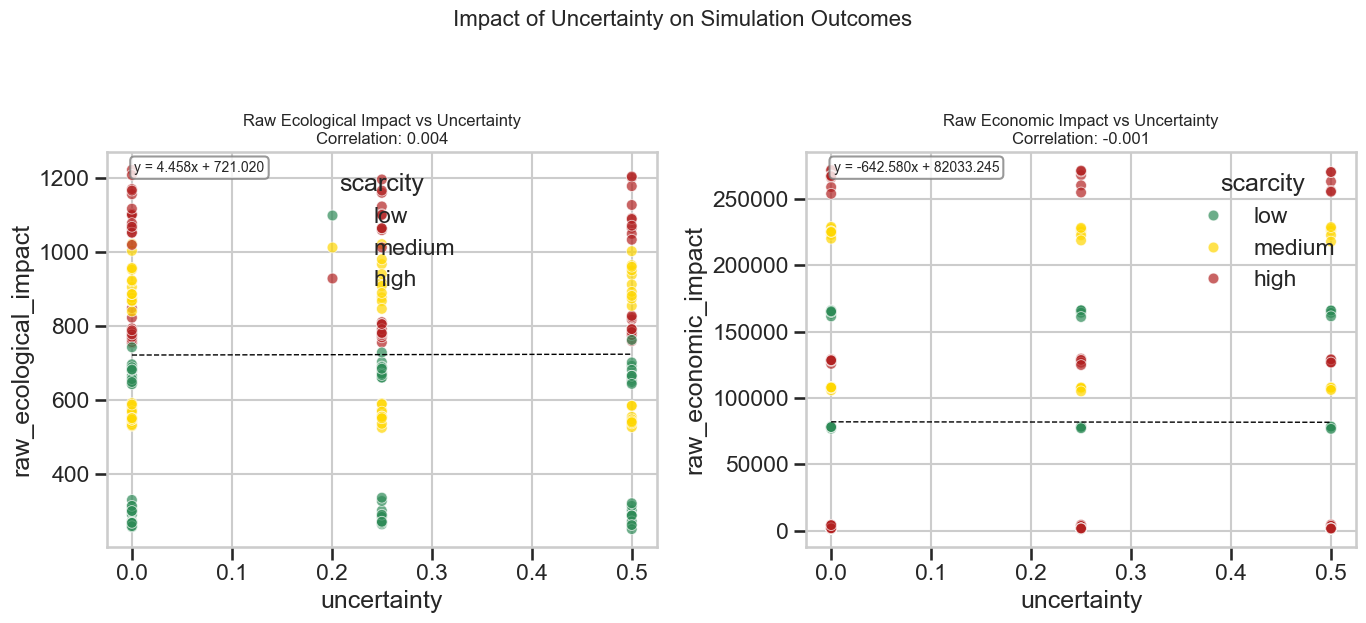

<Figure size 1200x1000 with 0 Axes>

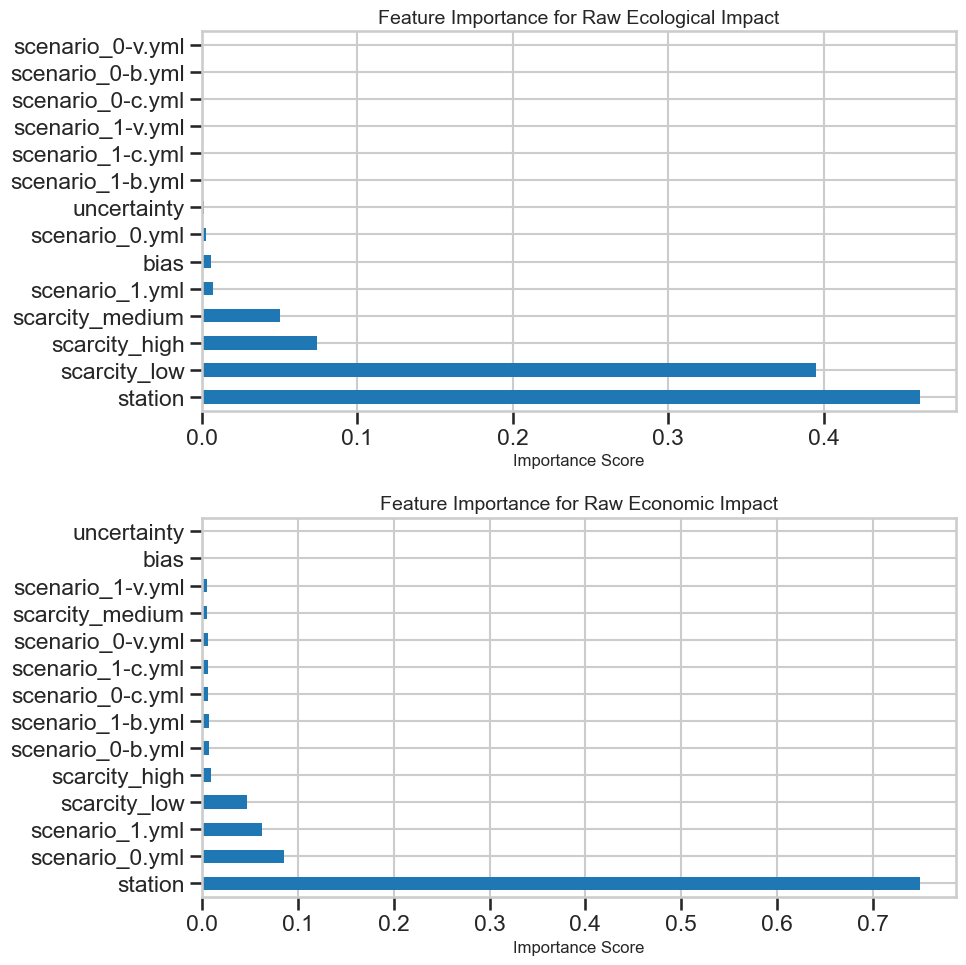

In [18]:
pma.correlation_analysis(results_df)

## Cooperation Analysis
Analyzing cooperation patterns across scenarios and their impact on ecological and economic outcomes.

c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon.Phase2\WaterScarcity.Hackathon\src\plot_multi_analysis.py:993: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


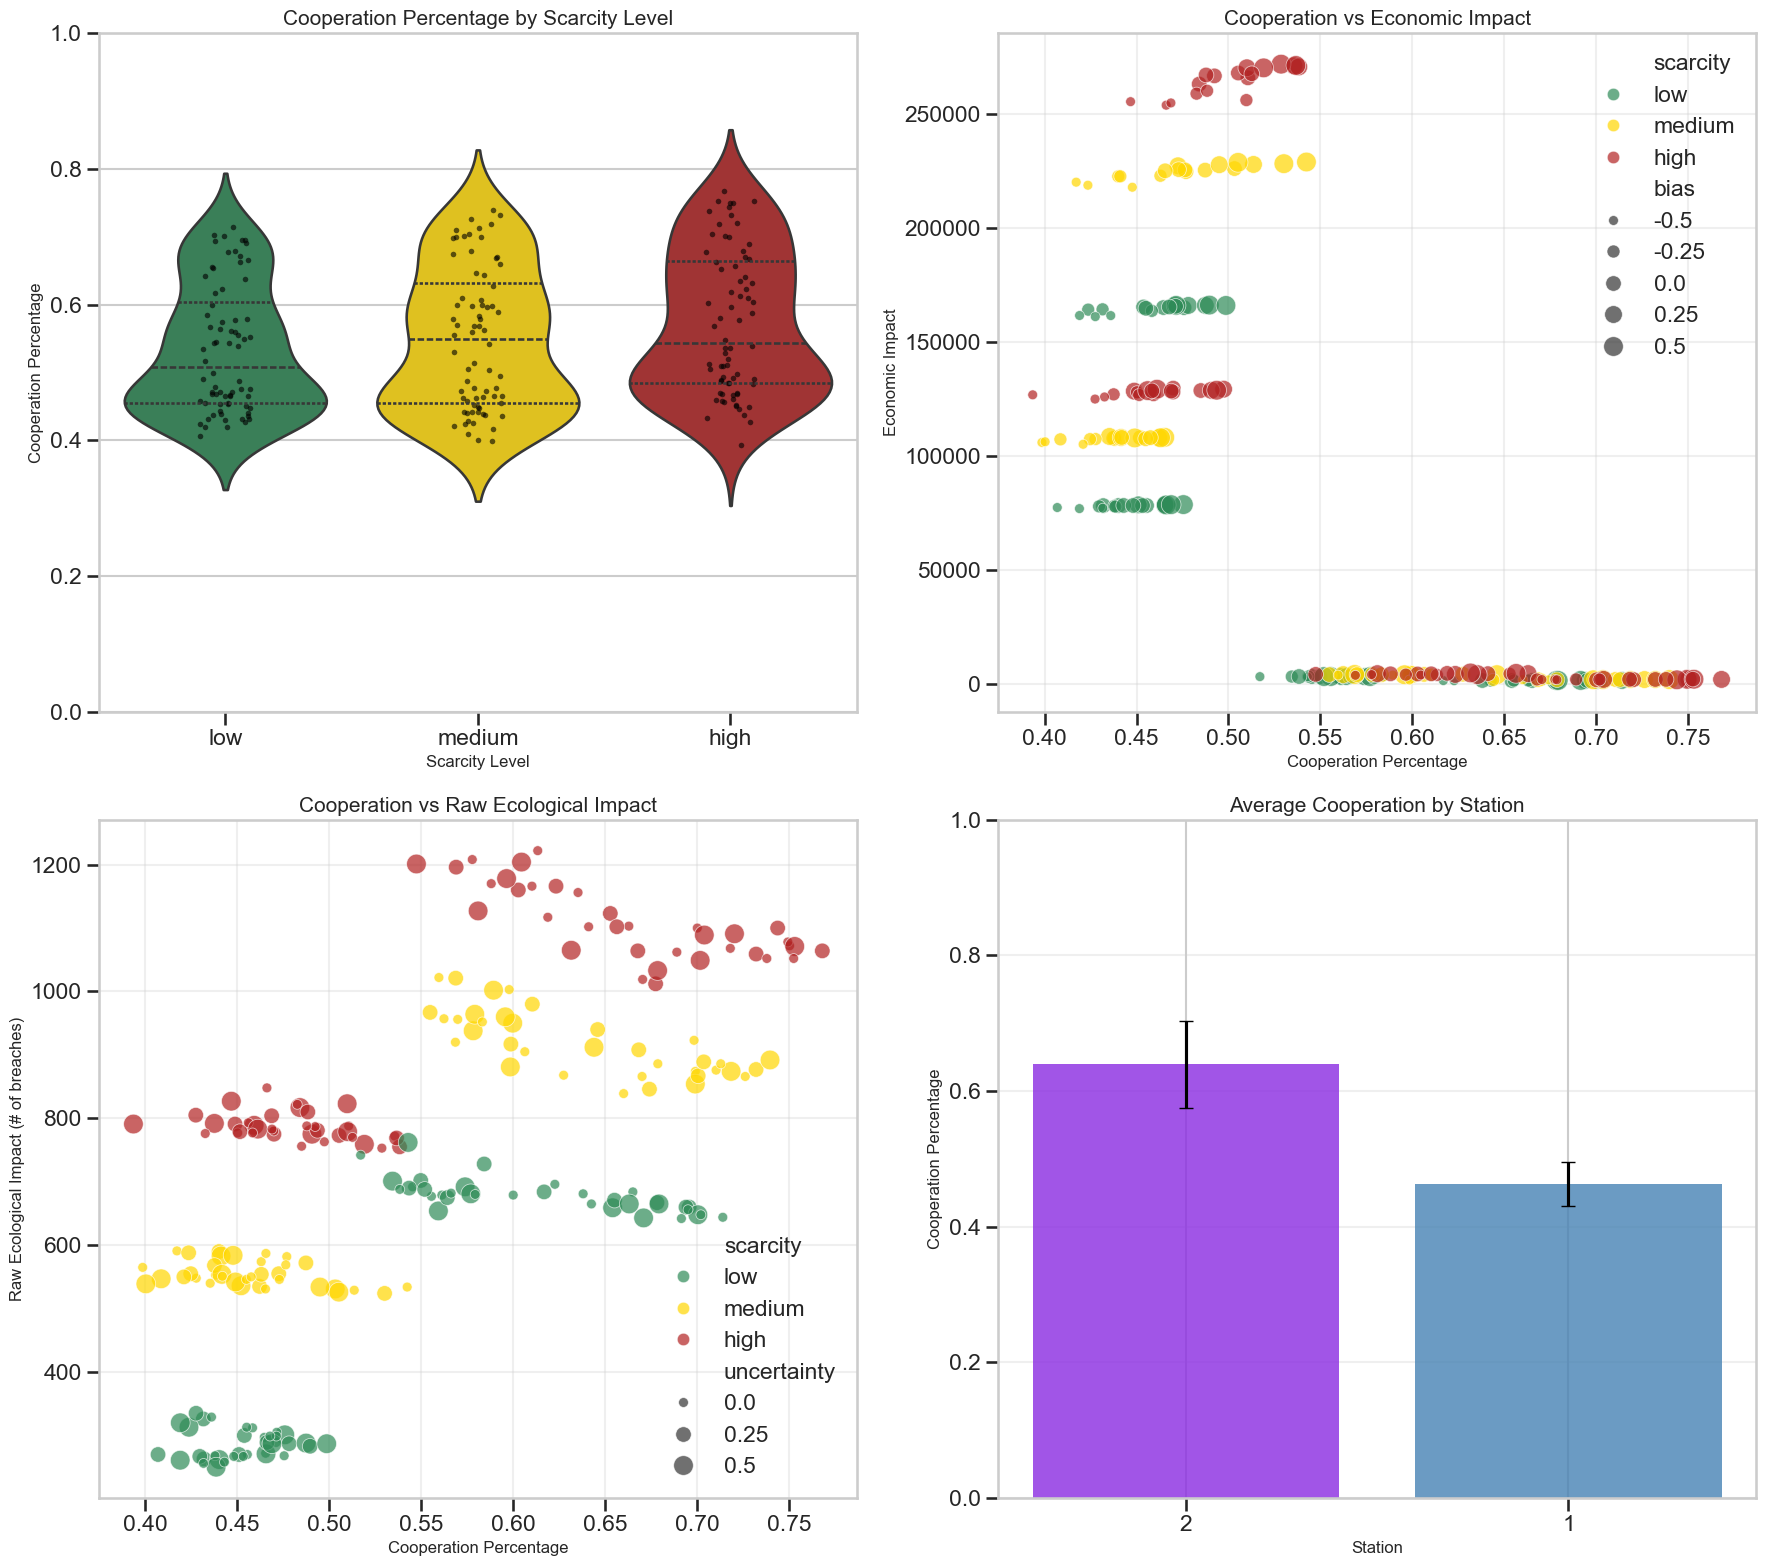

In [19]:
pma.analyze_cooperation_patterns(results_df)

## Raw Impact Vs Scalled Impact
Analyzing the raw (unscaled) ecological / economic impact against scalled impacts 

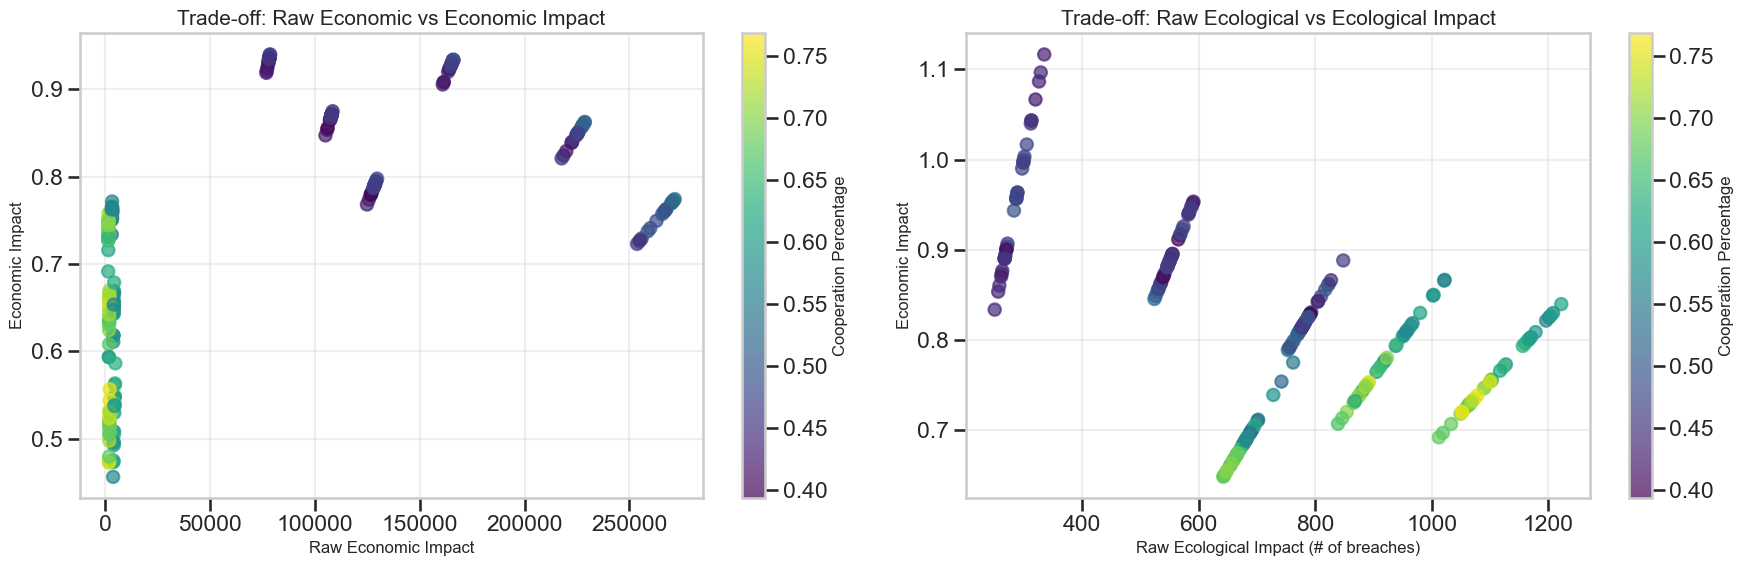

In [20]:
pma.analyze_raw_impact(results_df)

## Cooperation by Forecast Parameters
Analyzing how forecast bias and uncertainty affect cooperation levels.


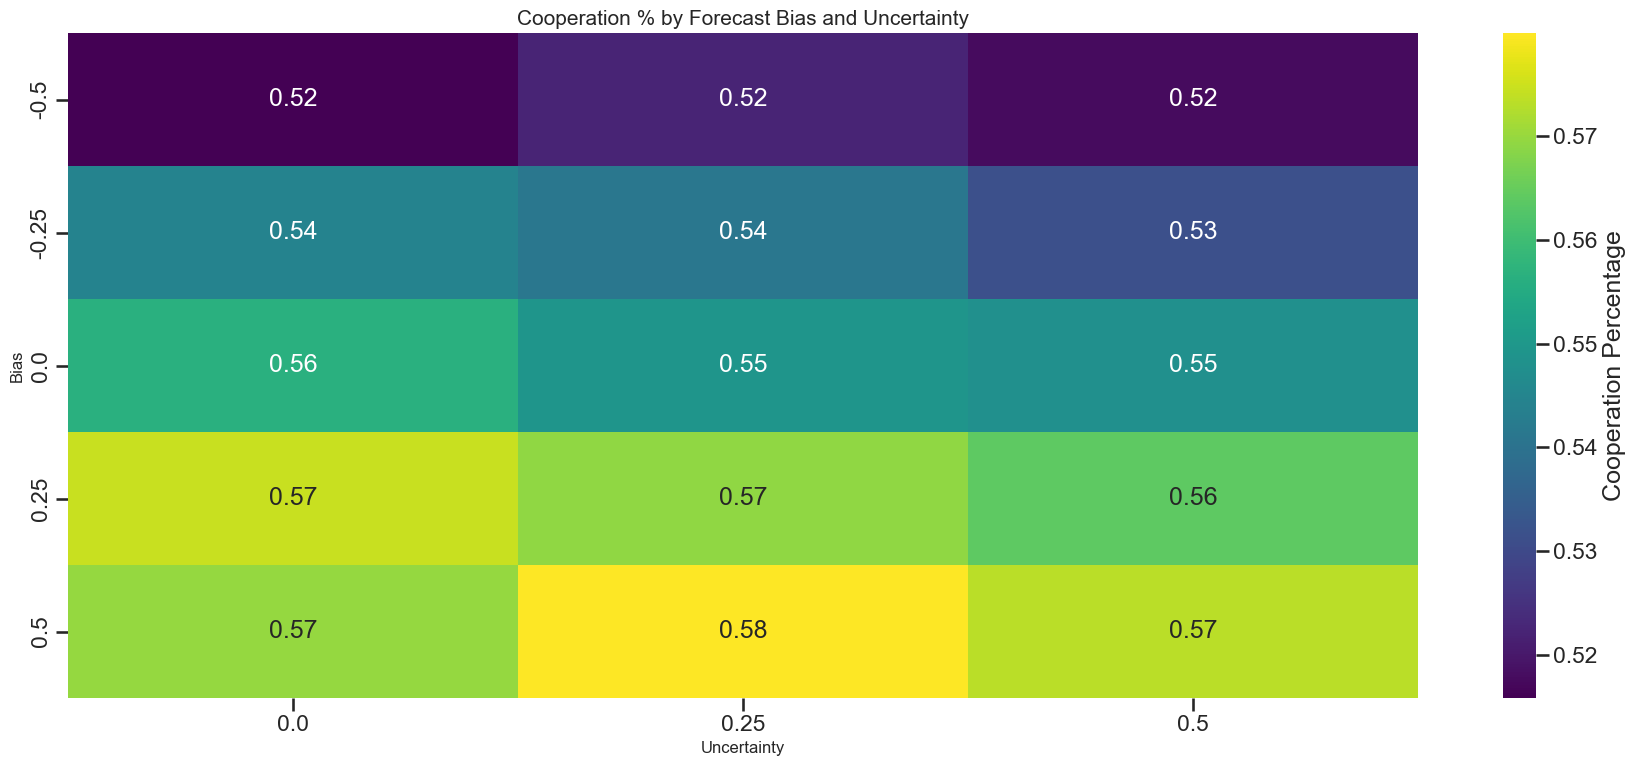

In [21]:
pma.analyze_cooperation_by_forecast_params(results_df)

## Comprehensive Analysis
Performing a comprehensive analysis of all metrics and their relationships.


=== Summary Statistics ===

Overall Metrics:
Average Cooperation: 0.55
Average Raw Ecological Impact: 721.9 breaches
Average Scaled Ecological Impact: 0.815
Average Economic Impact: 81899.375

Correlation Matrix:
                        cooperation_percentage  raw_ecological_impact  \
cooperation_percentage                    1.00                   0.66   
raw_ecological_impact                     0.66                   1.00   
ecological_impact                        -0.75                  -0.57   
economic_impact                          -0.78                  -0.96   
raw_economic_impact                      -0.68                  -0.45   
bias                                      0.18                  -0.03   
uncertainty                              -0.03                   0.00   

                        ecological_impact  economic_impact  \
cooperation_percentage              -0.75            -0.78   
raw_ecological_impact               -0.57            -0.96   
ecological_impac

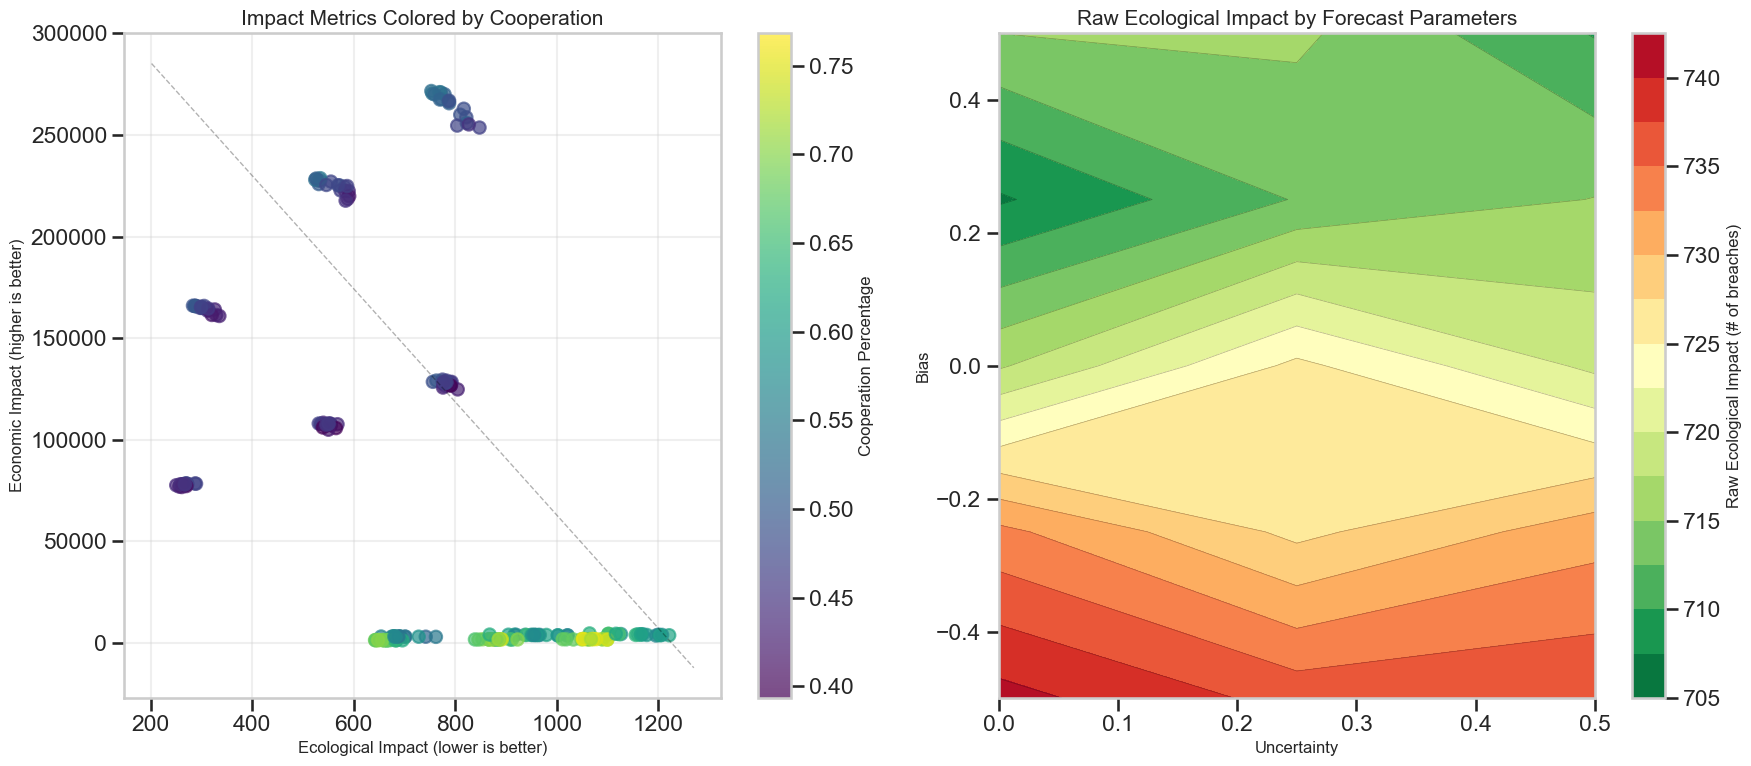

In [22]:
pma.comprehensive_analysis(results_df)

## Conclusion
This notebook has demonstrated how to analyze water allocation policies across multiple scenarios,
focusing on the balance between ecological and economic impacts. To participate in the hackathon:

1. Design your own adaptive policy by modifying the `custom_incentive_policy` and `custom_quota` functions
2. Test your policy across multiple scenarios using the tools provided
3. Optimize your policy to balance ecological integrity and economic benefits

Good luck!